## Section 1: Basic Simulation

In [1]:
from simulation import run_simulation


In [2]:
res_complete = run_simulation(
    lam=0.5, num_queries=200, scheduler_name="complete"
)

res_prefill = run_simulation(
    lam=0.5, num_queries=200, scheduler_name="prefill_first"
)

res_complete, res_prefill


[Single GPU][complete] finished 200 queries.
Simulation time window : 3.721 → 10484.521
Average throughput     : 0.019082512785283588
Average TTFT           : 4352.024083712498
Average TBT            : 393.8699999999992
Average total latency  : 10260.074083712487
[Single GPU][prefill_first] finished 200 queries.
Simulation time window : 3.721 → 5356.021
Average throughput     : 0.037367113203669436
Average TTFT           : 2341.5470837124976
Average TBT            : 186.00180000000015
Average total latency  : 5131.5740837125


({'scheduler_name': 'complete',
  'finished_queries': [Query(id=0, arrival_time=3.7212142221304467, L=64, B=16, decoded=16, phase=<QueryPhase.DONE: 3>, ttft=49.22121422213045, finish_time=10484.521214222119),
   Query(id=1, arrival_time=6.55847252807397, L=64, B=16, decoded=16, phase=<QueryPhase.DONE: 3>, ttft=94.72121422213044, finish_time=10484.521214222119),
   Query(id=2, arrival_time=7.649898819157156, L=64, B=16, decoded=16, phase=<QueryPhase.DONE: 3>, ttft=140.22121422213044, finish_time=10484.521214222119),
   Query(id=3, arrival_time=8.249183443584784, L=64, B=16, decoded=16, phase=<QueryPhase.DONE: 3>, ttft=185.72121422213044, finish_time=10484.521214222119),
   Query(id=4, arrival_time=9.681092943119085, L=64, B=16, decoded=16, phase=<QueryPhase.DONE: 3>, ttft=231.22121422213044, finish_time=10484.521214222119),
   Query(id=5, arrival_time=10.719259315522919, L=64, B=16, decoded=16, phase=<QueryPhase.DONE: 3>, ttft=276.72121422213047, finish_time=10484.521214222119),
   Quer

## Section 2: Lambda change

In [3]:
import numpy as np
import pandas as pd

lams = np.linspace(0.2, 1.0, 6)
rows = []

for lam in lams:
    r1 = run_simulation(lam=lam, scheduler_name="complete", num_queries=400)
    r2 = run_simulation(lam=lam, scheduler_name="prefill_first", num_queries=400)

    rows.append({
        "lam": lam,
        "sched": "complete",
        "throughput": r1["throughput"],
        "ttft": r1["avg_ttft"],
        "tbt": r1["avg_tbt"],
    })

    rows.append({
        "lam": lam,
        "sched": "prefill_first",
        "throughput": r2["throughput"],
        "ttft": r2["avg_ttft"],
        "tbt": r2["avg_tbt"],
    })

df = pd.DataFrame(rows)
df


[Single GPU][complete] finished 400 queries.
Simulation time window : 9.303 → 20550.103
Average throughput     : 0.019473438230253944
Average TTFT           : 8069.393356353126
Average TBT            : 761.2033333333326
Average total latency  : 19487.443356353113
[Single GPU][prefill_first] finished 400 queries.
Simulation time window : 9.303 → 10266.803
Average throughput     : 0.0389958566902267
Average TTFT           : 3495.6511063531284
Average TBT            : 380.5661499999977
Average total latency  : 9204.143356353115
[Single GPU][complete] finished 400 queries.
Simulation time window : 5.168 → 20545.968
Average throughput     : 0.019473438230253944
Average TTFT           : 8537.55186464063
Average TBT            : 761.2033333333326
Average total latency  : 19955.601864640616
[Single GPU][prefill_first] finished 400 queries.
Simulation time window : 5.168 → 10236.368
Average throughput     : 0.039096098209398744
Average TTFT           : 3988.2536146406246
Average TBT            

,lam,sched,throughput,ttft,tbt
0,0.20,complete,0.019473,8069.393356,761.203333
1,0.20,prefill_first,0.038996,3495.651106,380.566150
2,0.36,complete,0.019473,8537.551865,761.203333
3,0.36,prefill_first,0.039096,3988.253615,377.183217
4,0.52,complete,0.019473,8717.612829,761.203333
5,0.52,prefill_first,0.039096,4160.795079,377.684517
6,0.68,complete,0.019473,8812.939222,761.203333
7,0.68,prefill_first,0.039096,4240.293472,378.739717
8,0.84,complete,0.019473,8871.950799,761.203333
9,0.84,prefill_first,0.039096,4294.953549,379.029817


## Section 3: Visulization

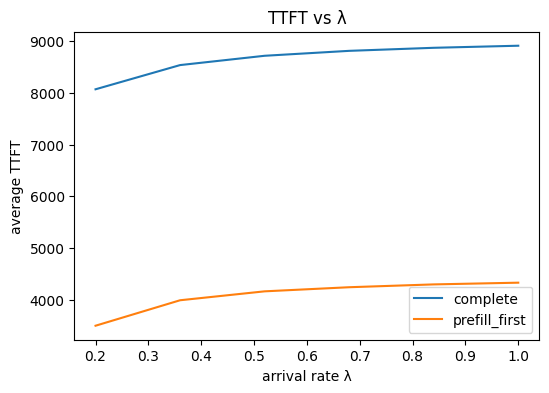

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
for sched in ["complete", "prefill_first"]:
    plt.plot(df[df.sched==sched].lam, df[df.sched==sched].ttft, label=f"{sched}")
plt.xlabel("arrival rate λ")
plt.ylabel("average TTFT")
plt.title("TTFT vs λ")
plt.legend()
plt.show()


## Section 4: MM1 Validation

In [5]:
from simulation import run_mm1_validation

run_mm1_validation(lam=0.5, mu=1.0)


[M/M/1] λ=0.5, μ=1.0, ρ=0.500
Average waiting time W_q (sim) : 0.9540152076059465
Average system time  W   (sim) : 1.9518010665709713


(0.9540152076059465, 1.9518010665709713)

In [7]:
lam = 0.5
mu = 1.0

W = 1/(mu-lam)
Wq = lam/(mu*(mu-lam))

print("Theoretical Wq:", Wq)
print("Theoretical W:", W)

Theoretical Wq: 1.0
Theoretical W: 2.0
